In [1]:
!pip install ccxt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 560.1 kB/s eta 0:00:001m220.7 kB/s eta 0:00:01
  Using cached aiodns-3.2.0-py3-none-any.whl.metadata (4.0 kB)
  Using cached pycares-4.4.0-cp312-cp312-macosx_10_9_universal2.whl.metadata (4.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 3.5 MB/s eta 0:00:003.5 MB/s eta 0:00:01
Using cached aiodns-3.2.0-py3-none-any.whl (5.7 kB)
Using cached pycares-4.4.0-cp312-cp312-macosx_10_9_universal2.whl (136 kB)


In [2]:
import asyncio
import json
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
async def test_get_kline_data(exchange:str, symbol:str, interval:str, size:int):
    exchanges = {
        'upbit' : {
            'url' : 'https://api.upbit.com/v1/candles/{}?market={}&count={}',
            'path_params' : ['minutes', 'days'],
            'query_params' : ['market', 'count'],
            'limit' : 200
        },
        'bithumb' : {
            'url' : 'https://api.bithumb.com/v1/candles/{}?market={}&count={}',
            'path_params' : ['minutes', 'days'],
            'query_params' : ['market', 'count'],
            'limit' : 200
        },
        'coinone' : {
            'url' : 'https://api.coinone.co.kr/public/v2/chart/KRW/{}?interval={}&size={}',
            'path_params' : ['target_currency'],
            'query_params' : ['interval', 'size'],
            'limit' : 500
        },
        'bybit' : {
            'url' : 'https://api.bybit.com/v5/market/kline?category=linear&symbol={}&interval={}&limit={}',
            'query_params' : ['category', 'symbol', 'interval', 'limit'],
            'limit' : 1000
        },
        'binance' : {
            'url' : 'https://fapi.binance.com/fapi/v1/klines?symbol={}&interval={}&limit={}',
            'query_params' : ['symbol', 'interval', 'limit'],
            'limit' : 1500
        },
        'okx' : {
            'url' : 'https://www.okx.com/api/v5/market/index-candles?instld={}&bar={}&limit={}',
            'query_params' : ['instld', 'bar', 'limit'],
            'limit' : 100
        },
        'bitget' : {
            'url' : 'curl "https://api.bitget.com/api/v2/mix/market/candles?symbol={}&granularity={}&limit={}}&productType=usdt-futures"',
            'query_params' : ['symbol', 'granularity', 'limit', 'productType'],
            'limit' : 1000
        }
    }

    spec = exchanges[exchange]

    import aiohttp

    async def aiocurl(url):
        async with aiohttp.ClientSession() as session:
            async with session.get(url) as response:
                if response.status == 200:
                    return await response.text()
                else:
                    print(f'Error: {response.status}')
                    return None
    
    query_string = spec['url']
    args = []

    if exchange == 'bybit':
        if interval[-1] in ['D', 'd', 'M', 'm']:
            interval = interval[-1].upper()
    
    if exchange in ['upbit', 'bithumb']:
        if interval[-1] == 'm':
            args.append('minutes')
        elif interval[-1] == 'd':
            args.append('days')
    
        args.append('KRW-' + symbol)
        args.append(size)

    else:
        if exchange != 'coinone':
            symbol += 'USDT'
        args.append(symbol)
        args.append(interval)
        args.append(size)

    query_string = spec['url'].format(*args)
    print(query_string)

    result = await aiocurl(query_string)
    result = json.loads(result)

    if isinstance(result, dict):
        print(len(result))
        print(result.keys())
    elif isinstance(result, list):
        print(len(result))

    if exchange == 'coinone':
        result = result['chart']
    elif exchange == 'bybit':
        result = result['result']['list']
    elif exchange in ['bitget', 'okx']:
        result = result['data']
    # print(json.dumps(result, indent=4))

    return result

In [15]:
async def test_calculate_kimp_historical_data(symbol:str, ex1:str, ex2:str, interval:str):
    krw_raw_data = await test_get_kline_data(ex1, symbol, interval, 500)
    usdt_raw_data = await test_get_kline_data(ex2, symbol, interval, 500)

    if ex2 in ['bybit']:
        columns = ['timestamp', 'open', 'high', 'low', 'close', 'target_volume', 'quote_volume']

    cols_to_convert = ['open', 'high', 'low', 'close', 'target_volume', 'quote_volume']

    krw_df = pd.DataFrame(krw_raw_data)
    krw_df['datetime'] = pd.to_datetime(krw_df.timestamp, unit='ms')
    krw_df[cols_to_convert] = krw_df[cols_to_convert].apply(pd.to_numeric)
    
    usdt_df = pd.DataFrame(usdt_raw_data, columns=columns)
    usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')
    usdt_df[cols_to_convert] = usdt_df[cols_to_convert].apply(pd.to_numeric)

    merged_df = pd.merge(krw_df, usdt_df, on='datetime', how='inner')
    merged_df['kimp'] = merged_df.close_x / merged_df.close_y

    return merged_df[['datetime', 'kimp']]

https://api.coinone.co.kr/public/v2/chart/KRW/BNT?interval=1d&size=500
4
dict_keys(['result', 'error_code', 'is_last', 'chart'])
https://api.bybit.com/v5/market/kline?category=linear&symbol=BNTUSDT&interval=D&limit=500
5
dict_keys(['retCode', 'retMsg', 'result', 'retExtInfo', 'time'])
https://api.bithumb.com/v1/candles/days?market=KRW-USDT&count=200
200


/var/folders/mb/3ygrx7qn76b_kfqy31wvkmz80000gn/T/ipykernel_11319/3140409496.py:15: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')


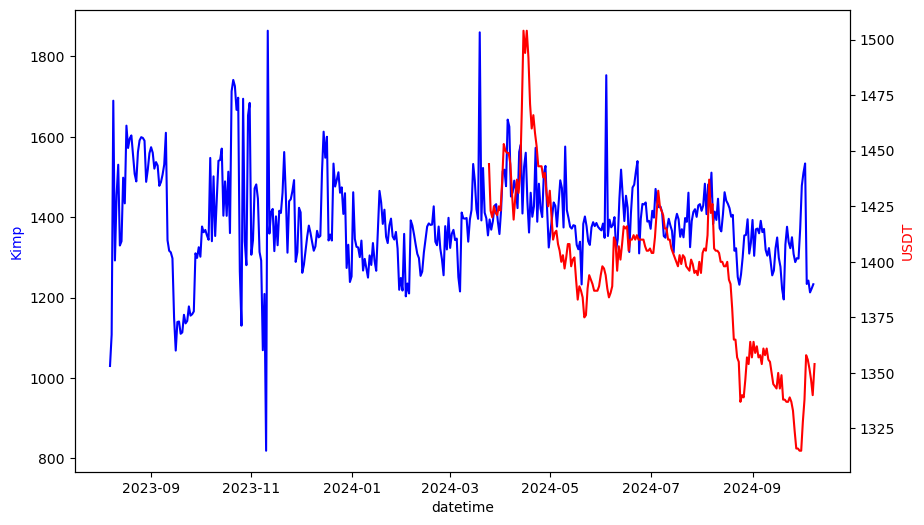

In [33]:
df = await test_calculate_kimp_historical_data('BNT', 'coinone', 'bybit', '1d')

usdt_data = await test_get_kline_data('bithumb', 'USDT', '1d', 200)
usdt_df = pd.DataFrame(usdt_data)
# print(usdt_df.info())
usdt_df = usdt_df[['timestamp', 'opening_price', 'high_price', 'low_price', 'trade_price']]
usdt_df['datetime'] = pd.to_datetime(usdt_df.timestamp, unit='ms')

import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 6))
p = sns.lineplot(x='datetime', y='kimp', data=df, color='b')
p.set_ylabel('Kimp', color='b')

ax2 = ax.twinx()
sns.lineplot(x='datetime', y='trade_price', data=usdt_df, ax=ax2, color='r')
ax2.set_ylabel('USDT', color='r')

plt.show()

In [34]:
async def fetch_orderbook(exchange, symbol, quote):
    target = symbol + '/' + quote
    try:
        return await exchange.fetch_order_book(target)
    except Exception as e:
        print(f"Error fetching orderbook for {target} on {exchange.id}: {e}")
        return None

In [35]:
def calculate_market_order_amount(orderbook, seed, is_buy, fee_rate):
    price_level = orderbook['asks'] if is_buy else orderbook['bids']

    if is_buy:
        # Reduce seed money by the fee
        effective_money = seed * (1 - fee_rate)
        total_fee = seed * fee_rate
        total_bought_coin = 0
        remaining_money = effective_money

        try:
            if len(price_level[0]) == 2:
                # Iterate through the ask prices and calculate the amount of coins you can buy
                for price, volume in price_level:
                    if remaining_money >= price * volume:
                        total_bought_coin += volume
                        remaining_money -= price * volume
                    else:
                        total_bought_coin += remaining_money / price
                        break
            elif len(price_level[0]) == 3:
                for price, volume, _ in price_level:
                    if remaining_money >= price * volume:
                        total_bought_coin += volume
                        remaining_money -= price * volume
                    else:
                        total_bought_coin += remaining_money / price
                        break
            else:
                raise ValueError
        except Exception as e:
            print(price_level)
            raise e

        return total_bought_coin, total_fee

    else:
        total_revenue = 0
        remaining_coins = seed

        # Iterate through the bids to calculate revenue
        try:
            if len(price_level[0]) == 2:
                for price, volume in price_level:
                    if remaining_coins >= volume:
                        total_revenue += price * volume
                        remaining_coins -= volume
                    else:
                        total_revenue += price * remaining_coins
                        break
            elif len(price_level[0]) == 3:
                for price, volume, _ in price_level:
                    if remaining_coins >= volume:
                        total_revenue += price * volume
                        remaining_coins -= volume
                    else:
                        total_revenue += price * remaining_coins
                        break
            else:
                raise ValueError
        except Exception as e:
            print(price_level)
            raise e

        # Reduce revenue by the selling fee
        return total_revenue * (1 - fee_rate), total_revenue * fee_rate

In [ ]:
import ccxt.async_support as ccxt

exchange_class = getattr(ccxt, 'coinone')
ex1 = exchange_class()

exchange_class = getattr(ccxt, 'bybit')
ex2 = exchange_class()

